In [1]:
# !pip install  scikit-learn pandas matplotlib tqdm gradio
# !pip install kagglehub
# !pip[ install torch torchvision

In [2]:
# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder, ImageFolder

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Misc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import kagglehub
from PIL import Image

# Subject to change
import gradio as gr

C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Function to find imaghes because I have a custom folder structure that is hard to load directly
def find_images(folder_path, label):
    images = []
    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            images.append((os.path.join(folder_path, file), label))
    return images

data_dir = kagglehub.dataset_download("bharathry/glaucoma-dataset-for-ai-diagnosis-v2")
print("Downloaded at:", data_dir)

# Point to the actual subfolder that contains glaucoma/ and normal/ because the dataset is nested with folders
data_dir = os.path.join(data_dir, "Glaucoma Dataset for AI Diagnosis")
print("Current Data Dir:", data_dir)
print("Top-Level Folders:", os.listdir(data_dir))

glaucoma_images = find_images(os.path.join(data_dir, "glaucoma"), 1)
normal_images = find_images(os.path.join(data_dir, "normal"), 0)

all_images = glaucoma_images + normal_images

# Stratified train/val split because we have an imbalanced dataset
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(
    range(len(all_images)),
    test_size=0.2,
    stratify=[label for _, label in all_images],
    random_state=42
)

train_split = [all_images[i] for i in train_idx]
val_split = [all_images[i] for i in val_idx]

print("Train samples:", len(train_split))
print("Val samples:", len(val_split))

Downloaded at: C:\Users\bhara\.cache\kagglehub\datasets\bharathry\glaucoma-dataset-for-ai-diagnosis-v2\versions\1
Current Data Dir: C:\Users\bhara\.cache\kagglehub\datasets\bharathry\glaucoma-dataset-for-ai-diagnosis-v2\versions\1\Glaucoma Dataset for AI Diagnosis
Top-Level Folders: ['glaucoma', 'normal']
Train samples: 2527
Val samples: 632


In [4]:
# Custom dataset class I creasted to traverse the custom folder structure properly
class CustomDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

IMG_SIZE = 224
BATCH_SIZE = 32

# Augmented transform for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Simpler transform for validation
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train_split, transform=train_transform)
val_dataset = CustomDataset(val_split, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [5]:
# Load the pre-trained MobileNetV3 model so I can train it on my custom dataset
model = models.mobilenet_v3_large(pretrained=True)

model.classifier[2] = nn.Dropout(p=0.4)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\cuda\__init__.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 30
PATIENCE = 5 # Early stopping patience, I need this because my model overfits quickly and easily on my dataset even after augmenting it

# These next four lines were so I could make graphs for training and validation losses and accuracies
# I don't need to change these, but I will leave them here for reference
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
all_val_preds_by_epoch = []
all_val_labels_by_epoch = []

best_val_loss = float("inf")
best_weights = None
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    epoch_val_preds = []
    epoch_val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            epoch_val_preds.extend(preds.cpu().numpy())
            epoch_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Store epoch-wise predictions
    all_val_preds_by_epoch.append(epoch_val_preds)
    all_val_labels_by_epoch.append(epoch_val_labels)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}% | "
        f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            break

# Load best model
model.load_state_dict(best_weights)
torch.save(best_weights, "best_glaucoma_model.pth")

Epoch 1/30:   0%|          | 0/79 [00:01<?, ?it/s]


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


IndexError: list index out of range

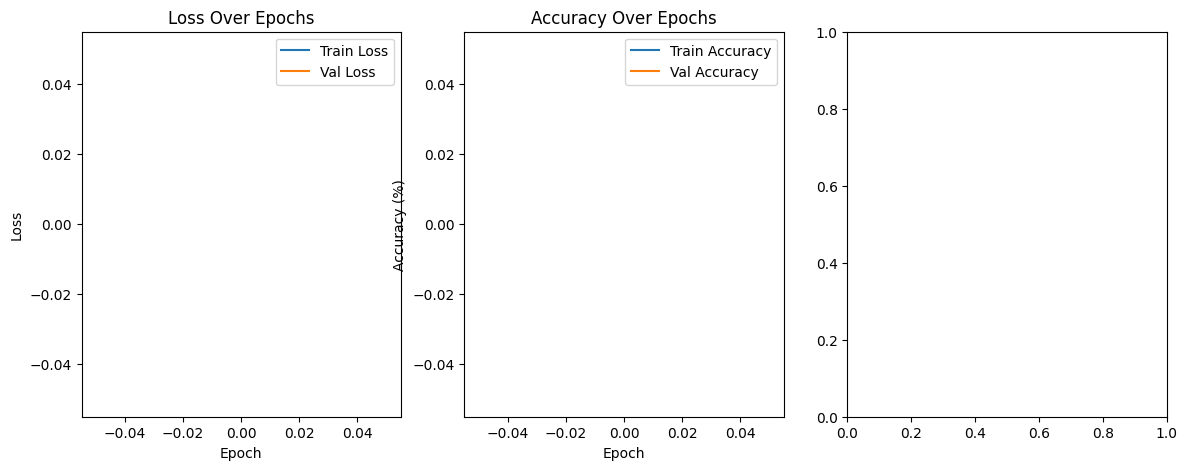

In [ ]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(epoch_val_labels, epoch_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Glaucoma"])
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.xticks(rotation=45)
plt.title("Confusion Matrix")

plt.tight_layout()
plt.savefig("glaucoma_results.png")
plt.show()


In [ ]:
import cv2
import torchvision.transforms.functional as F

def generate_gradcam(model, image_tensor, target_class, device):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Hook the gradients of the target layer
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    target_layer = model.features[-1]
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    output = model(image_tensor)
    class_score = output[0, target_class]
    model.zero_grad()
    class_score.backward()

    # Cleanup hooks
    forward_handle.remove()
    backward_handle.remove()

    # Compute weights
    grad = gradients[0]
    act = activations[0]
    pooled_grad = torch.mean(grad, dim=[0, 2, 3])
    weighted_act = (act[0] * pooled_grad[:, None, None]).sum(dim=0)

    # Normalize heatmap
    heatmap = weighted_act.cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    return heatmap


In [ ]:
# Save the best model weights
torch.save(best_weights, "best_glaucoma_model.pth")
print("Best model weights saved to best_glaucoma_model.pth")

2.5.1+cu121
True
NVIDIA GeForce RTX 5070


C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\cuda\__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5070 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90.
If you want to use the NVIDIA GeForce RTX 5070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


In [ ]:
import cv2
import torchvision.transforms.functional as F

def overlay_gradcam_on_image(image_tensor, heatmap):
    image_np = F.to_pil_image(image_tensor.cpu()).convert("RGB")
    image_np = np.array(image_np)

    # Resize heatmap to match image size
    heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Overlay heatmap on image
    overlayed_img = cv2.addWeighted(image_np, 0.6, heatmap_color, 0.4, 0)
    return overlayed_img

In [ ]:
!ls -lh best_glaucoma_model.pth

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

val_metrics = {
    "accuracy": [],
    "recall": [],
    "f1_score": []
}

# Compute metrics per epoch
for epoch_preds, epoch_labels in zip(all_val_preds_by_epoch, all_val_labels_by_epoch):
    val_metrics["accuracy"].append(accuracy_score(epoch_labels, epoch_preds))
    val_metrics["recall"].append(recall_score(epoch_labels, epoch_preds))
    val_metrics["f1_score"].append(f1_score(epoch_labels, epoch_preds))

# Plot them
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(val_metrics["accuracy"], label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 2)
plt.plot(val_metrics["recall"], label="Recall", color="orange")
plt.title("Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")

plt.subplot(1, 3, 3)
plt.plot(val_metrics["f1_score"], label="F1 Score", color="green")
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()
